You can download the dataset from https://www.kaggle.com/datasets/sylar68/spacecraft-thruster-firing-test-dataset

       So Each file is a 1-hour long fire test run for a specific inlet propellant pressure (between 8 and 24 bar).
       The thruster is operated with a single ON-OFF command. The status of the command is provided in the ton column.
       The thrust and mfr columns are respectively the measured thrust (in Newtons) and measured mass flow rate (in mg/s) recorded at 100 Hz frequency.


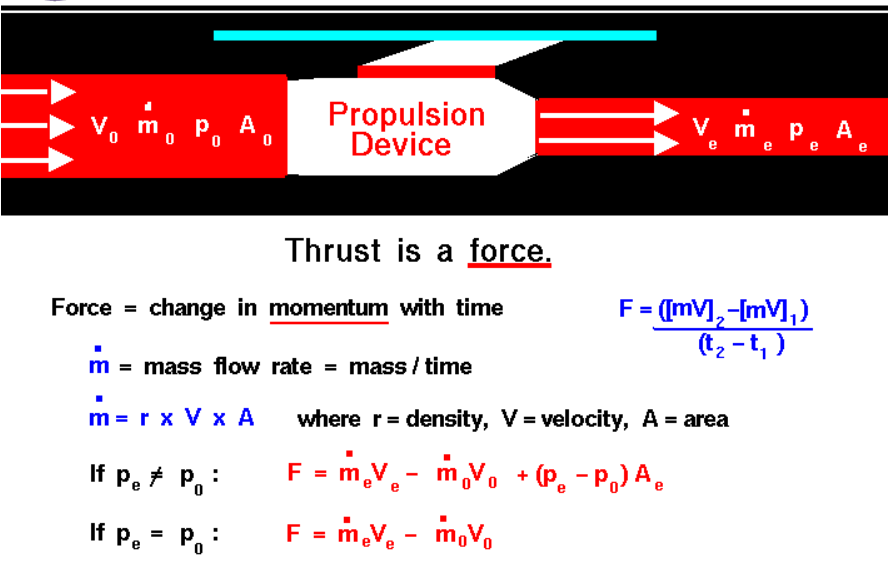

    The Mass Flow Rate is the mass of a liquid substance passing per unit time.
    Thrust is the force which moves any aircraft through the air.
    
Amount of thrust generated depends on the mass flow through the engine

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


In [4]:
df=pd.read_csv('data/SN01_20_30.csv')
df.head()

,Unnamed: 0,ton,thrust,mfr
0,2021-03-04 09:16:00.000,0.0,-0.001365,0.0
1,2021-03-04 09:16:00.010,0.0,0.002536,0.0
2,2021-03-04 09:16:00.020,0.0,0.000726,0.0
3,2021-03-04 09:16:00.030,0.0,-0.006169,0.0
4,2021-03-04 09:16:00.040,0.0,0.001169,0.0


In [5]:
df.tail()

,Unnamed: 0,ton,thrust,mfr
359995,2021-03-04 10:15:59.950,0.0,0.092150,46.909064
359996,2021-03-04 10:15:59.960,0.0,0.091639,40.844849
359997,2021-03-04 10:15:59.970,0.0,0.084069,35.056915
359998,2021-03-04 10:15:59.980,0.0,0.062724,30.118214
359999,2021-03-04 10:15:59.990,0.0,0.040863,25.403094


In [6]:
df.describe()

,ton,thrust,mfr
count,360000.000000,360000.000000,360000.000000
mean,0.514983,0.287798,142.529759
std,0.499776,0.277921,131.155940
min,0.000000,-0.028561,0.000000
25%,0.000000,0.001444,0.037024
50%,1.000000,0.248824,127.757139
75%,1.000000,0.533475,263.641401
max,1.000000,1.146875,337.633485


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  360000 non-null  object 
 1   ton         360000 non-null  float64
 2   thrust      360000 non-null  float64
 3   mfr         360000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 11.0+ MB


In [8]:
df['ton'].value_counts()

1.0    185394
0.0    174606
Name: ton, dtype: int64

In [9]:
df['mfr'].value_counts()

0.000000      73701
256.462538        1
256.747926        1
257.376168        1
256.935047        1
              ...  
98.384790         1
104.058295        1
110.617883        1
116.055191        1
25.403094         1
Name: mfr, Length: 286300, dtype: int64

### Lets plot the first 5000 sequence 

In [12]:
def load_and_plot_example(filename="12_25", start_frame=0, end_frame=5000,jj="Title"):
    df = pd.read_csv("data/SN01_"+filename+".csv")
    df.index = df["Unnamed: 0"]
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.index.name="date"
    df["thrust"][start_frame:end_frame].plot(figsize=(20,4), c="r")
    df["ton"][start_frame:end_frame].plot(figsize=(20,4), c="k")
    (df["mfr"][start_frame:end_frame]/1000).plot(figsize=(20,4), c="g")
    plt.title(jj)
    plt.legend()
    plt.show() 
    

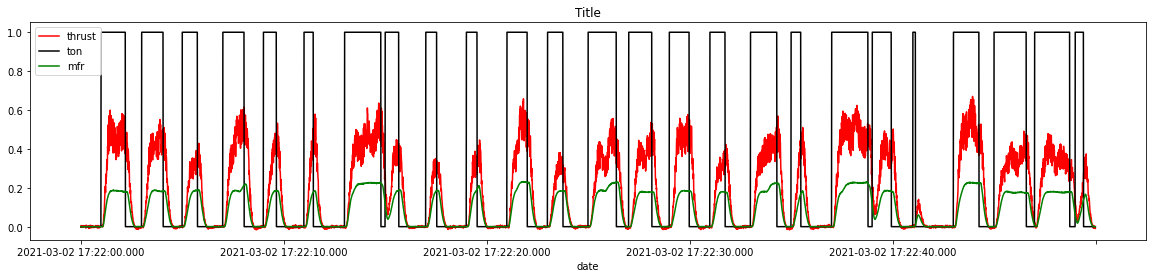

In [13]:
load_and_plot_example("12_16")

In [14]:
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])

In [16]:
#for minutes
df[:6000+1]

,Unnamed: 0,ton,thrust,mfr
0,2021-03-04 09:16:00.000,0.0,-0.001365,0.000000
1,2021-03-04 09:16:00.010,0.0,0.002536,0.000000
2,2021-03-04 09:16:00.020,0.0,0.000726,0.000000
3,2021-03-04 09:16:00.030,0.0,-0.006169,0.000000
4,2021-03-04 09:16:00.040,0.0,0.001169,0.000000
...,...,...,...,...
5996,2021-03-04 09:16:59.960,1.0,0.756178,320.281171
5997,2021-03-04 09:16:59.970,1.0,0.958024,320.174667
5998,2021-03-04 09:16:59.980,1.0,0.665211,318.540358
5999,2021-03-04 09:16:59.990,1.0,0.773026,317.870813


In [17]:
#forseconds
df[:100+1]

,Unnamed: 0,ton,thrust,mfr
0,2021-03-04 09:16:00.000,0.0,-0.001365,0.0
1,2021-03-04 09:16:00.010,0.0,0.002536,0.0
2,2021-03-04 09:16:00.020,0.0,0.000726,0.0
3,2021-03-04 09:16:00.030,0.0,-0.006169,0.0
4,2021-03-04 09:16:00.040,0.0,0.001169,0.0
...,...,...,...,...
96,2021-03-04 09:16:00.960,0.0,-0.005624,0.0
97,2021-03-04 09:16:00.970,0.0,-0.002222,0.0
98,2021-03-04 09:16:00.980,0.0,-0.002715,0.0
99,2021-03-04 09:16:00.990,0.0,-0.000448,0.0


### Let's Visualise the first 1 minute data of specific inlet propellant pressure

In [18]:
def plot_minutes_interval(filename="12_25", interval=6000,jj="Title"):
    df = pd.read_csv("data/SN01_"+filename+".csv")
    df.index = df["Unnamed: 0"]
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.index.name="date"
    df["thrust"][::interval].plot(figsize=(20,4), c="r")
    df["ton"][::interval].plot(figsize=(20,4), c="k")
    (df["mfr"][::interval]/1000).plot(figsize=(20,4), c="g")
    plt.title(jj)
    plt.legend()
    plt.show() 

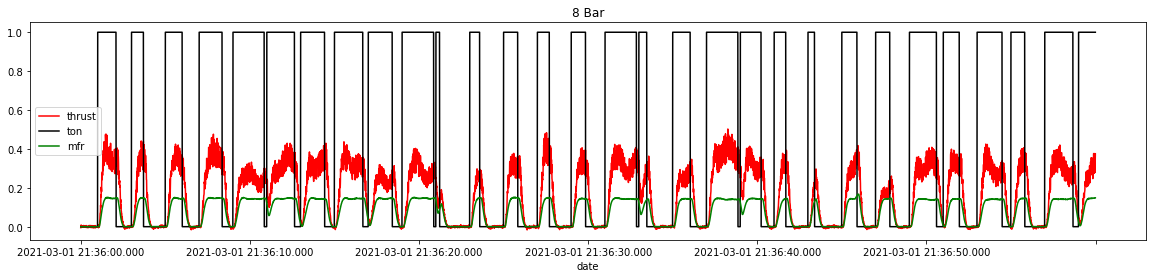

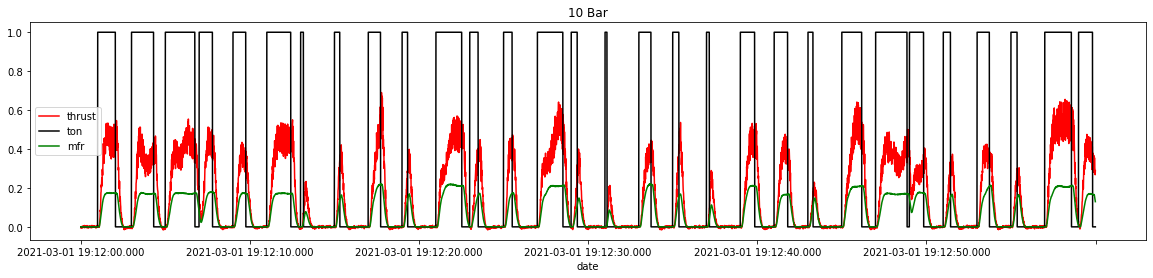

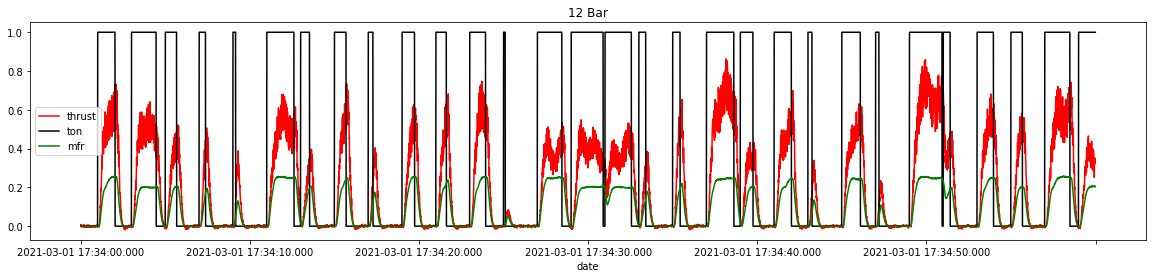

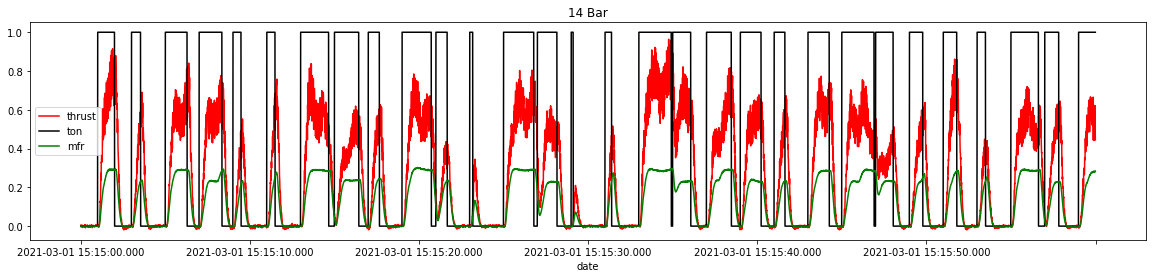

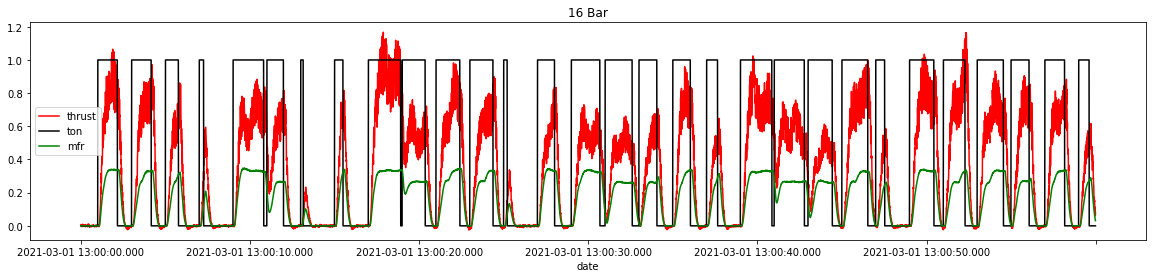

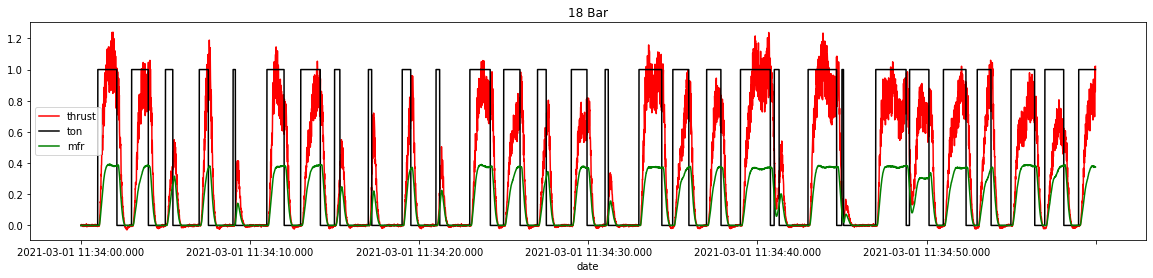

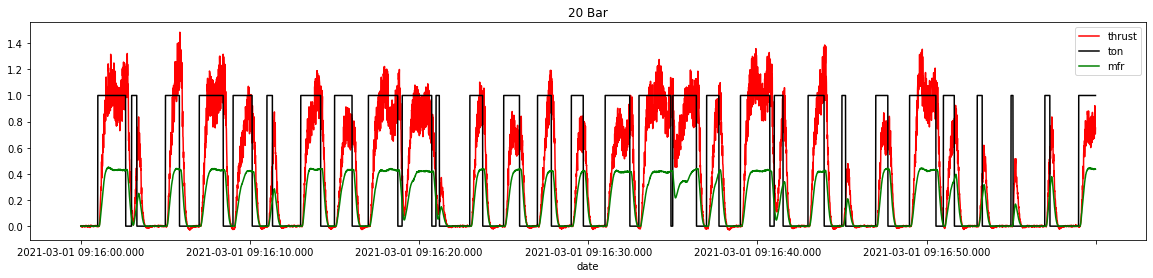

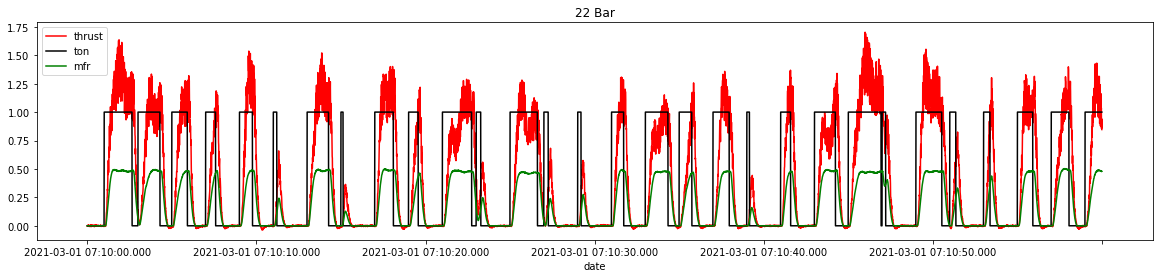

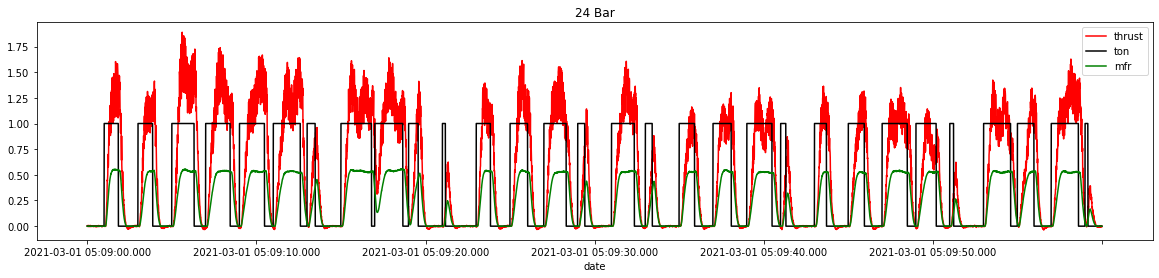

In [19]:
for i in ["8_9","10_8","12_7","14_6","16_5","18_4","20_3","22_2","24_1"]:
    load_and_plot_example(filename=i,start_frame=0, end_frame=6000,jj=i[:-2]+' Bar')

## Now Let's plot the whole sequence  minute wise

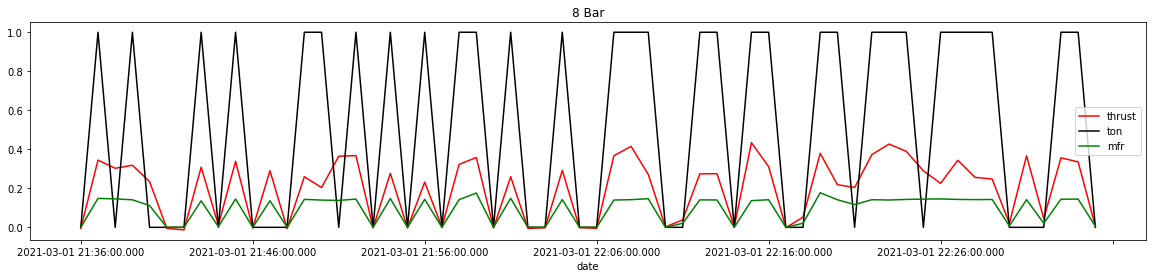

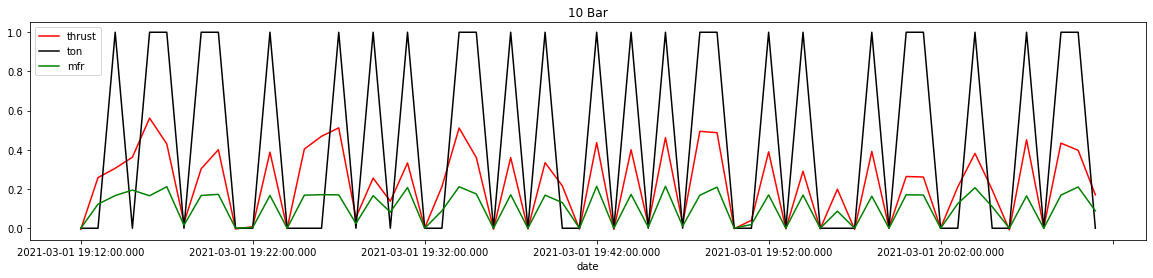

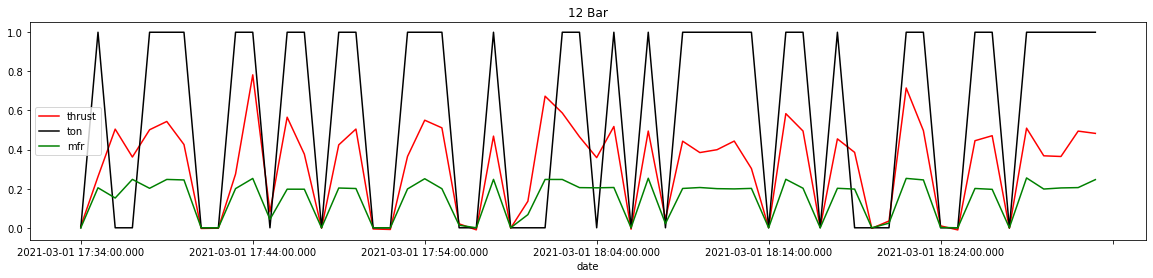

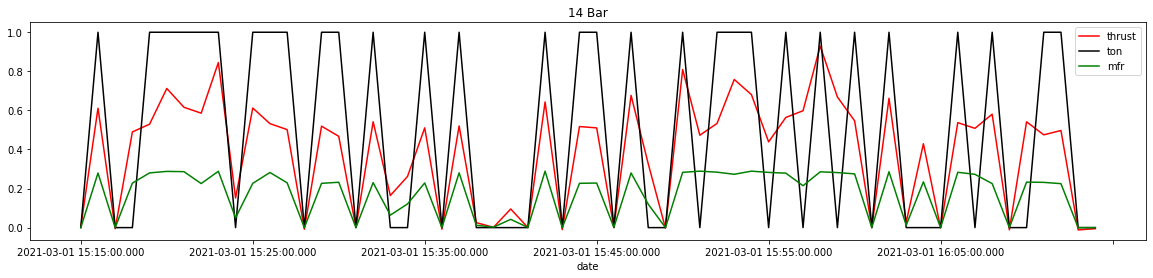

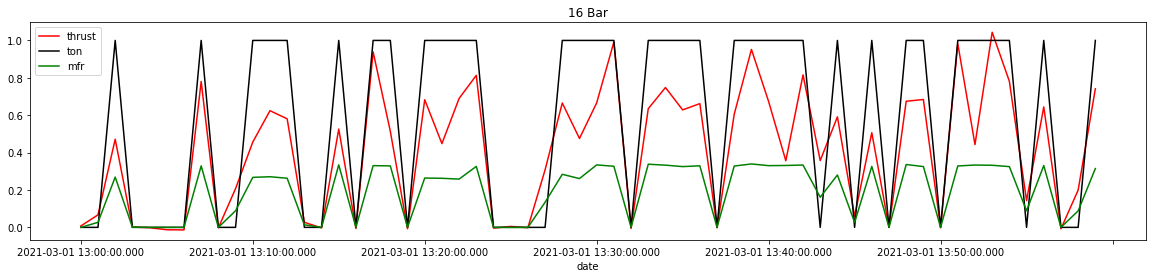

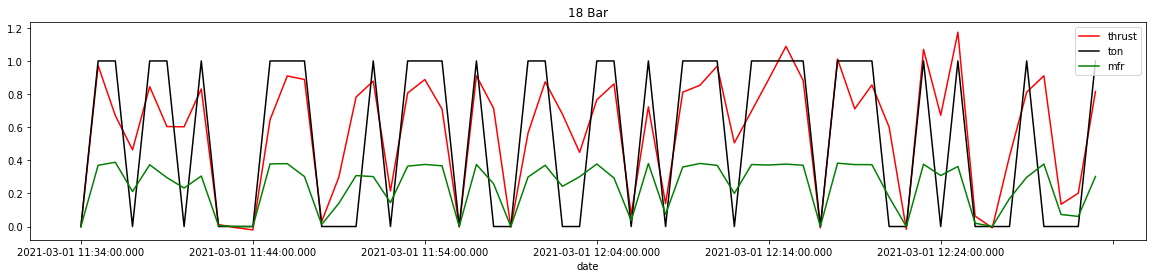

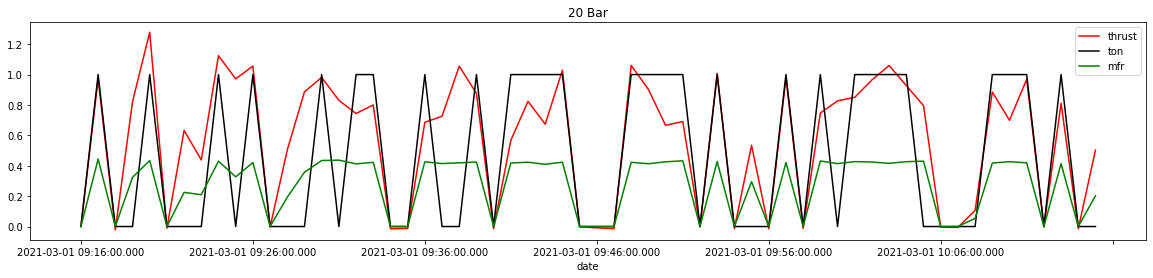

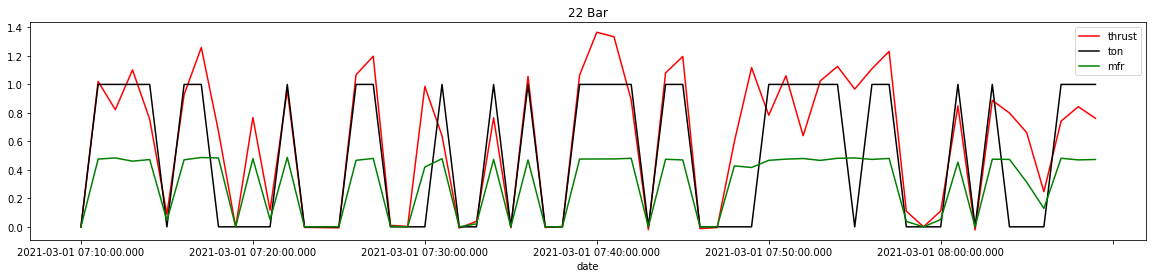

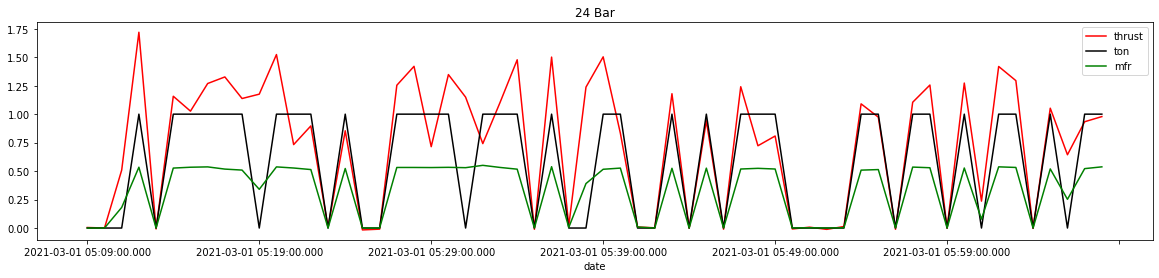

In [20]:
for i in ["8_9","10_8","12_7","14_6","16_5","18_4","20_3","22_2","24_1"]:
    plot_minutes_interval(filename=i, interval=6000, jj=i[:-2]+' Bar')
#     load_and_plot_example(filename=i,start_frame=0, end_frame=6000,)

## As the specific inlet propellant pressure increases the thrust and mass flow rate also increases which is true from general thrust equation above

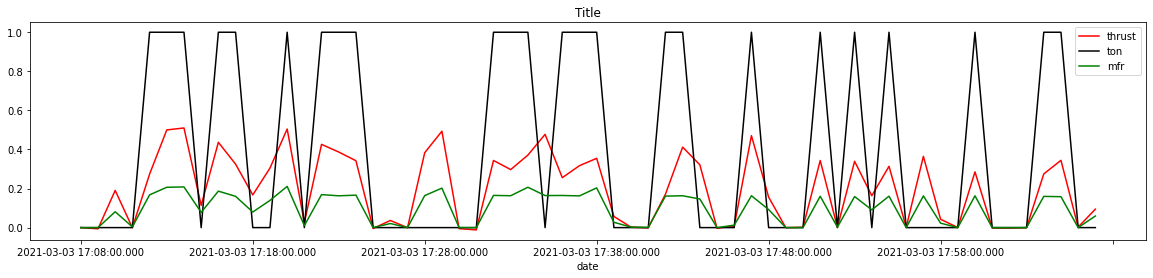

In [22]:
plot_minutes_interval(filename="12_25", interval=6000)